# "fastBook | Ch5 Improving Our Model"

> fastBook ch5
- toc: false
- comments: true
- categories: [fastai]
- badges: true

## Improving Our Model

**The Takeaway**    
- better training techniques
- transfer learning
- fine-tuning with pretrained model (weights)
- find optimal learning rate & # epochs

### The Learning Rate Finder

### The Learning Rate Finder

training을 잘하기 위해서 좋은 learning rate를 찾는 것이 중요하다. learning rate가 너무 큰 경우에는 발산을 하게 되고 너무 작은 경우에는 overfitting의 우려가 있다. 적절한 learning rate를 어떻게 찾을까?  
</br>  
기존에 알고 있던 learning rate 적용 방법  
- 고정된 learning rate  
- 처음에는 큰 learning rate로 학습하다가 점차적으로 / 지수적으로 learning rate를 줄여나가는 방법  
</br>  

learning rate finder (Leslie Smith, 2015)   
- CLR (cyclical learning rate) : 주기적 학습률    
- 학습률이 고정되거나 감소하는 대신 CLR는 학습률이 합리적인 최소값과 최대값 사이를 지속적으로 오가는 것을 허용  
- 아주 작은 learning rate로 시작해서 매 일정한 비율로 (예, doubled)로 증가시키면서 매 epoch 마다 적용  
- minimum learning rate를 증가시키면서 매 epoch의 loss를 관찰하다가 loss가 나빠지는 지점의 learning rate보다 조금 작은 값의 learning rate를 설정 
</br>  
fastai에서는 lr_find() 함수를 사용하여 다음 두 지점 계산 가능 (default lr : 1e-03)    
- 최소 손실이 도달한 지점의 앞 단계 (예: the minimum divided by 10)  
- 손실은 분명히 줄어들고 있던 마지막 지점  

</br>  

Leslie Smith는 의 1주기 정책(1cycle policy) 관련 논문  

- Cyclical Learning Rates for Training Neural Networks (2017)
- Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (2018)
- A disciplined approach to neural network hyper-parameters: Part1 - learning rate, batch size, momentum, and weight decay (2018)

</br>  
만약 learning rate가 크다면 어떠한 일이 생길까?

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.778816,5.150732,0.504060,00:20


epoch,train_loss,valid_loss,error_rate,time
0,4.354680,3.003533,0.834235,00:24


learning rate가 너무 커서 좋지 않은 결과를 보임.  
</br> 
fastai의 lr_find() 함수이용

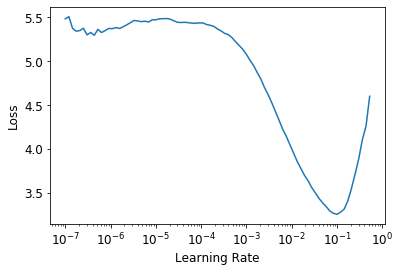

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 5.25e-03


1e-2, 1e-3의 중간 지점으로 3e-3 선택  
(logarithmic sacle이기 때문에 1e-2, 1e-3의 중간 지점은 4e-3, 3e-3이 됨)  

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.328591,0.344678,0.114344,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.540180,0.420945,0.127876,00:24
1,0.329827,0.248813,0.083221,00:24


1950년대부터 NN의 발전해왔음에도 불구하고 learning rate에 대한 연구는 2015년이 되서야 Leslie Smith에 의해 활성화 되었다. 실리콘밸리 직원도 아닌 narval 연구원이었던 것을 보면 딥러닝 연구에 정말 필요한 것은 상식, 창의력, 끈기 등이 아닐까..

### Unfreezing and Transfer Learning


fine_tuning 시에는 pre_training 된 모델을 가져와서 마지막 layer를 제거하고 (사전학습에 이용된 데이터에 대한 문제를 풀기 위한 마지막 레이어이므로) 우리의 과제에 맞는 출력 수를 가진 새로운 선형 계층으로 대체한다. (pet breeds 과제의 경우 37개의 활성화 존재) 

</br>

이후 fine_tuning 할때에는 pre_training 시에 학습된 일반화된 규칙성을 가지면서 마지막 레이어만 우리의 문제를 풀수 있는 모델로 학습하는 과정이 필요함.  

이 때 기존 layer에 대한 weight는 업데이트 하지 않고 새롭게 추가된 마지막 레이어에 대해서만 weight 값을 조정하면 이러한 효과를 볼 수 있다. 이를 달성하기 위해 사전 훈련된 layer는 freeze할 필요가 있다. (fastai에서는 사전 훈련된 모델로 학습할 때 자동으로 모든 계층을 freezing함.)

fastai는 fine_tune 메소드를 호출할 때 두 가지 작업을 수행 
- 다른 모든 레이어가 freeze 된 상태에서 임의로 추가된 레이어를 한 epoch에 대해 train  
- 모든 레이어의 unfreeze 하고 에폭 수 만큼 모든 레이어를 train  

In [ ]:
learn.fine_tune??

train the randomly added layers for three epochs, using fit_one_cycle

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.188042,0.355024,0.102842,00:20
1,0.534234,0.302453,0.094723,00:20
2,0.325031,0.222268,0.074425,00:20


Then we'll unfreeze the model:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

(1.0964782268274575e-05, 1.5848931980144698e-06)

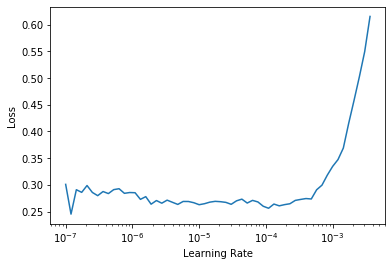

In [ ]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

Let's train at a suitable learning rate:

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.263579,0.217419,0.069012,00:24
1,0.253060,0.210346,0.062923,00:24
2,0.224340,0.207357,0.060217,00:24
3,0.200195,0.207244,0.061570,00:24
4,0.194269,0.200149,0.059540,00:25
5,0.173164,0.202301,0.059540,00:25


This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

### Discriminative Learning Rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

In addition, do you remember the images we saw in <<chapter_intro>>, showing what each layer learns? The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning that we will introduce in <<chapter_nlp>>. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). The idea is based on insights developed by [Jason Yosinski](https://arxiv.org/abs/1411.1792), who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds, as seen in <<yosinski>>.

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="images/att_00039.png">

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.145300,0.345568,0.119756,00:20
1,0.533986,0.251944,0.077131,00:20
2,0.317696,0.208371,0.069012,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.257977,0.205400,0.067659,00:25
1,0.246763,0.205107,0.066306,00:25
2,0.240595,0.193848,0.062246,00:25
3,0.209988,0.198061,0.062923,00:25
4,0.194756,0.193130,0.064276,00:25
5,0.169985,0.187885,0.056157,00:25
6,0.153205,0.186145,0.058863,00:25
7,0.141480,0.185316,0.053451,00:25
8,0.128564,0.180999,0.051421,00:25
9,0.126941,0.186288,0.054127,00:25


Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

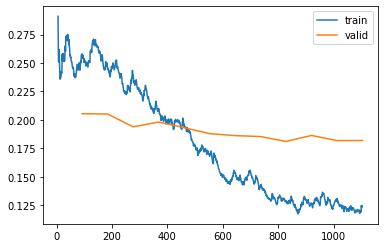

In [ ]:
learn.recorder.plot_loss()

### test  
generalization / accurcy 보다 시간 때문에 epoch 수를 제한하는 경우가 많다. 여유가 되는 시간만큼 epoch를 할당하여 훈련하고 training / validation loss / metrics를 살펴본다. 마지막 epoch까지 성능이 좋아지고 있다면 더 많은 epoch로 훈련할 필요가 있다.  
</br> 
모델 성능이 악화되고 있는 경우에는 validation loss 보다 실제 metrics 값에 주목하라. validation loss는 optimizer를 최적화하기 위해 쓰이는 것이지 우리가 실제로 사용할 것이 아님을 명심하라.
</br>   
1 cycle training이 나오기 전에는 각 epoch마다 모델을 저장하고 전체 모델 중 성능이 가장 높은 모델을 선정하는 것이 (early stopping) 일반적이었다. 하지만 이 방법은 최적의 learning rate를 찾기 전에 중간 지점의 epoch에서 저장된 모델을 선택할 수 있기 때문에 모델 학습이 overfitting 되는 것이 발견되면 더 낮은 수의 epoch를 선택하여 모델을 처음부터 re-training 시켜야 한다.



generalization / accurcy 보다 시간 때문에 epoch 수를 제한하는 경우가 많다. 여유가 되는 시간만큼 epoch를 할당하여 훈련하고 training / validation loss / metrics를 살펴본다. 마지막 epoch까지 성능이 좋아지고 있다면 더 많은 epoch로 훈련할 필요가 있다.  
</br> 
모델 성능이 악화되고 있는 경우에는 validation loss 보다 실제 metrics 값에 주목하라. validation loss는 optimizer를 최적화하기 위해 쓰이는 것이지 우리가 실제로 사용할 것이 아님을 명심하라.
</br>   
1 cycle training이 나오기 전에는 각 epoch마다 모델을 저장하고 전체 모델 중 성능이 가장 높은 모델을 선정하는 것이 (early stopping) 일반적이었다. 하지만 이 방법은 최적의 learning rate를 찾기 전에 중간 지점의 epoch에서 저장된 모델을 선택할 수 있기 때문에 모델 학습이 overfitting 되는 것이 발견되면 더 낮은 수의 epoch를 선택하여 모델을 처음부터 re-training 시켜야 한다.



generalization / accurcy 보다 시간 때문에 epoch 수를 제한하는 경우가 많다. 여유가 되는 시간만큼 epoch를 할당하여 훈련하고 training / validation loss / metrics를 살펴본다. 마지막 epoch까지 성능이 좋아지고 있다면 더 많은 epoch로 훈련할 필요가 있다.  
</br> 
모델 성능이 악화되고 있는 경우에는 validation loss 보다 실제 metrics 값에 주목하라. validation loss는 optimizer를 최적화하기 위해 쓰이는 것이지 우리가 실제로 사용할 것이 아님을 명심하라.
</br>   
1 cycle training이 나오기 전에는 각 epoch마다 모델을 저장하고 전체 모델 중 성능이 가장 높은 모델을 선정하는 것이 (early stopping) 일반적이었다. 하지만 이 방법은 최적의 learning rate를 찾기 전에 중간 지점의 epoch에서 저장된 모델을 선택할 수 있기 때문에 모델 학습이 overfitting 되는 것이 발견되면 더 낮은 수의 epoch를 선택하여 모델을 처음부터 re-training 시켜야 한다.



As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does *not* mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

### Selecting the number of epochs

generalization / accurcy 보다 시간 때문에 epoch 수를 제한하는 경우가 많다. 여유가 되는 시간만큼 epoch를 할당하여 훈련하고 training / validation loss / metrics를 살펴본다. 마지막 epoch까지 성능이 좋아지고 있다면 더 많은 epoch로 훈련할 필요가 있다.  
</br> 
모델 성능이 악화되고 있는 경우에는 validation loss 보다 실제 metrics 값에 주목하라. validation loss는 optimizer를 최적화하기 위해 쓰이는 것이지 우리가 실제로 사용할 것이 아님을 명심하라.
</br>   
1 cycle training이 나오기 전에는 각 epoch마다 모델을 저장하고 전체 모델 중 성능이 가장 높은 모델을 선정하는 것이 (early stopping) 일반적이었다. 하지만 이 방법은 최적의 learning rate를 찾기 전에 중간 지점의 epoch에서 저장된 모델을 선택할 수 있기 때문에 모델 학습이 overfitting 되는 것이 발견되면 더 낮은 수의 epoch를 선택하여 모델을 처음부터 re-training 시켜야 한다.

generalization / accurcy 보다 시간 때문에 epoch 수를 제한하는 경우가 많다. 여유가 되는 시간만큼 epoch를 할당하여 훈련하고 training / validation loss / metrics를 살펴본다. 마지막 epoch까지 성능이 좋아지고 있다면 더 많은 epoch로 훈련할 필요가 있다.  
</br> 
모델 성능이 악화되고 있는 경우에는 validation loss 보다 실제 metrics 값에 주목하라. validation loss는 optimizer를 최적화하기 위해 쓰이는 것이지 우리가 실제로 사용할 것이 아님을 명심하라.
</br>   
1 cycle training이 나오기 전에는 각 epoch마다 모델을 저장하고 전체 모델 중 성능이 가장 높은 모델을 선정하는 것이 (early stopping) 일반적이었다. 하지만 이 방법은 최적의 learning rate를 찾기 전에 중간 지점의 epoch에서 저장된 모델을 선택할 수 있기 때문에 모델 학습이 overfitting 되는 것이 발견되면 더 낮은 수의 epoch를 선택하여 모델을 처음부터 re-training 시켜야 한다.

### Deeper Architectures


일반적으로 parameter가 더 많은 모델은 데이터를 더 정확하게 모델링할 수 있다. 간단하게 layer를 추가할 수도 있지만 pretrained model 중 몇 개 층의 layer로 구성된 모델을 쓸 지 선택할 수 있다. (ResNet의 경우 with 18, 34, 50, 101, and 152 layer, pretrained on ImageNet)  

deeper model에서 "Cuda runtime error: out of memory"의 문제가 발생할 경우
- Dataloader의 bs를 줄이기
- mixed-precision training 사용  
  : using less-precise numbers (half-precision floating point, also called fp16)   
  : 사용 - learner 파라미터로 to_fp16() 추가

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.427505,0.310554,0.098782,00:21
1,0.606785,0.302325,0.094723,00:22
2,0.409267,0.294803,0.091340,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.261121,0.274507,0.083897,00:26
1,0.296653,0.318649,0.084574,00:26
2,0.242356,0.253677,0.069012,00:26
3,0.150684,0.251438,0.065629,00:26
4,0.094997,0.239772,0.064276,00:26
5,0.061144,0.228082,0.054804,00:26


generalization / accurcy 보다 시간 때문에 epoch 수를 제한하는 경우가 많다. 여유가 되는 시간만큼 epoch를 할당하여 훈련하고 training / validation loss / metrics를 살펴본다. 마지막 epoch까지 성능이 좋아지고 있다면 더 많은 epoch로 훈련할 필요가 있다.  
</br> 
모델 성능이 악화되고 있는 경우에는 validation loss 보다 실제 metrics 값에 주목하라. validation loss는 optimizer를 최적화하기 위해 쓰이는 것이지 우리가 실제로 사용할 것이 아님을 명심하라.
</br>   
1 cycle training이 나오기 전에는 각 epoch마다 모델을 저장하고 전체 모델 중 성능이 가장 높은 모델을 선정하는 것이 (early stopping) 일반적이었다. 하지만 이 방법은 최적의 learning rate를 찾기 전에 중간 지점의 epoch에서 저장된 모델을 선택할 수 있기 때문에 모델 학습이 overfitting 되는 것이 발견되면 더 낮은 수의 epoch를 선택하여 모델을 처음부터 re-training 시켜야 한다.